# Implement Convolutional Neural Networks components

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Zero padding

In [2]:
def zero_pad(X, pad):
    """
    Arguments:
    X - data type is numpy array, shape (m, H, W, C)
    pad - data type is integer, amount of padding around each image on vertical and horizontal
    """
    padded_X = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), "constant", constant_values=0)
    return padded_X

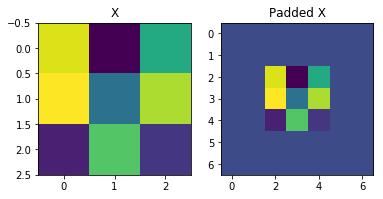

In [3]:
np.random.seed(1)
m = 4 # Number of sample
H = 3 # Height
W = 3 # Width
C = 2 # Channel

X = np.random.randn(m, H, W, C)
padded_X = zero_pad(X, 2)

fig, axes = plt.subplots(1, 2)
axes[0].set_title("X")
axes[0].imshow(X[0, :, :, 0])
axes[1].set_title("Padded X")
axes[1].imshow(padded_X[0, :, :, 0])

## Forward propagation


### Convolutional layer forward

$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor + 1 $

$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor + 1 $

$ n_C = \text{Number of filters used in the convolution} $

In [4]:
def single_step_conv(a_slice_prev, W, b):
    """
    Arguments:
    a_slice_prev - data type is numpy array, shape is (f, f, C_prev)
    W - data type is numpy array, Weights matrix, shape is (f, f, C_prev)
    b - data type is numpy array, bias matrix, shape is (1, 1, 1)
    
    Returns:
    Z - a scalar value, result of convolving the sliding window (W, b) on a slice x of he input data
    """
    
    single = np.multiply(a_slice_prev, W)
    Z = np.sum(single)
    Z = Z + float(b)
    return Z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4 ,3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
Z = single_step_conv(a_slice_prev, W, b)
print("Z = {}".format(Z))

Z = -6.999089450680221


In [6]:
def conv_forward(A_prev, W, b, hyper_params):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hyper_params["stride"]
    pad = hyper_params["pad"]
    
    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    padded_A_prev = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_padded_prev = padded_A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w * stride + f
                    
                    a_slice_prev = a_padded_prev[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = single_step_conv(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
    
    cache = (A_prev, W, h, hyper_params)
    return Z, cache

In [7]:
np.random.randn(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hyper_params = {"pad": 2, "stride": 2}


Z, conv_cache = conv_forward(A_prev, W, b, hyper_params)
print("Z.shape = {}".format(Z.shape))
print("Z[4, 2, 1, :] = {}".format(Z[4, 2, 1, :]))

Z.shape = (10, 4, 4, 8)
Z[4, 2, 1, :] = [-0.20555171  6.23776201  2.00711797  0.76155097 -6.17175943  0.2447692
  5.37072111  3.46037289]


### Pooling layer forward

The pooling layer reduces the dimations of the intpu.

$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor + 1 $

$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor + 1 $

$ n_C = n_{C_{prev}} $

In [8]:
def pool_forward(A_prev, hyper_params, mode="max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hyper_params["f"]
    stride = hyper_params["stride"]
    
    n_H = int((n_H_prev - f) / stride + 1)
    n_W = int((n_W_prev - f) / stride + 1)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w * stride + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hyper_params)
    return A, cache

In [9]:
np.random.randn(1)
A_prev = np.random.randn(2, 4, 4, 3)
hyper_params = {"stride": 2, "f": 2}

A, cache = pool_forward(A_prev, hyper_params)

print("A_prev = {}".format(A_prev))
print("A = {}".format(A))

A_prev = [[[[ 2.50598029e+00  1.91979229e+00 -1.39169388e+00]
   [ 4.50217742e-01  6.27437083e-01  7.51337235e-01]
   [ 1.40395436e-01 -9.26871939e-01 -1.82420406e-01]
   [-4.91125138e-01  1.34373116e-01 -2.68371304e-01]]

  [[-1.31675626e-01  1.01855247e+00  1.23055820e+00]
   [-1.18110317e+00 -4.59930104e-01 -7.90799954e-01]
   [ 1.22372221e+00 -5.93679025e-02  1.44898940e+00]
   [-4.77580855e-01  2.59999942e-02 -1.34869645e+00]]

  [[ 1.30253554e+00 -3.62612088e-01 -1.48515645e+00]
   [-5.92461285e-01 -2.30490794e+00 -3.18171727e-02]
   [ 1.12487742e-01  2.88078167e-01  1.49810818e+00]
   [-3.00976154e-01  8.07455917e-01  3.12238689e-01]]

  [[-1.93321640e-01 -2.07680202e+00  9.47501167e-01]
   [-5.03973949e-01  1.79558917e-02 -1.27046078e+00]
   [ 2.82995534e-01  1.08030817e-01  2.94176190e-02]
   [-1.34793129e-01  1.04921829e+00  9.66220863e-01]]]


 [[[ 7.25916853e-01  3.32107876e+00 -6.00225330e-01]
   [-3.79517516e-01 -1.01480369e+00  4.35986196e-01]
   [-6.87487393e-01 -2.6983

## Backward propagation

### Convolutional layer backward

$ dA = \sum_{n_H}^{h = 0} \sum_{n_w}^{w = 0} W_c \times dZ_{hw} $

$ dW_c  += \sum_{n_H}^{h = 0} \sum_{n_W}^{w = 0} a_{slice} \times dZ_{hw} $

$ db = \sum_{h} \sum_{w} dZ_{hw} $

In [10]:
def conv_backward(dZ, cache):
    (A_prev, W, b, hyper_params) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hyper_params["stride"]
    pad = hyper_params["pad"]
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    padded_A_prev = zero_pad(A_prev, pad)
    padded_dA_prev = zero_pad(dA_prev, pad)
    
    for i in range(m):
        padded_a_prev = padded_A_prev[i]
        padded_da_prev = padded_dA_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w * stride + f
                    
                    a_slice = padded_a_prev[vert_start:vert_end, horiz_start:horiz_end, :]
                    padded_da_prev[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, C] * dZ[i , h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
        dA_prev[i, :, :, :] = padded_da_prev[pad:-pad, pad:-pad, :]
    return dA_prev, dW, db
    

In [11]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, conv_cache)
print("dA.shape = {}".format(dA.shape))
print("dW.shape = {}".format(dW.shape))
print("db.shape = {}".format(db.shape))

dA.shape = (10, 4, 4, 3)
dW.shape = (2, 2, 3, 8)
db.shape = (1, 1, 1, 8)


### Pooling layer backward

* Max pooling

$ X = \begin{bmatrix} 1 \quad 3 \\ 4 \quad 2 \end{bmatrix} \quad M = \begin{bmatrix} 0 \quad 0 \\ 1 \quad 0 \end{bmatrix} $

* Average pooling

$ dZ = 1 \rightarrow dZ = \begin{bmatrix} 1/4 \quad 1/4 \\ 1/4 \quad 1/4 \end{bmatrix} $

In [12]:
def create_maxk_from_window(x):
    mask = (x == np.max(x))
    return mask

In [13]:
np.random.seed(1)
x = np.random.randn(2, 2)
mask = create_maxk_from_window(x)
print("x = {}".format(x))
print("mask = {}".format(mask))

x = [[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]]
mask = [[ True False]
 [False False]]


In [14]:
def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average
    return a

In [15]:
a = distribute_value(2, (2, 2))
print("Distribute value = {}".format(a))

Distribute value = [[0.5 0.5]
 [0.5 0.5]]


In [16]:
def pool_backward(dA, cache, mode="max"):
    (A_prev, hyper_params) = cache
    f = hyper_params["f"]
    stride = hyper_params["stride"]
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (m, n_H, n_W, n_C) = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = h * stride + f
                    horiz_start = w * stride
                    horiz_end = w * stride + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_maxk_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    return dA_prev

In [17]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hyper_params = {"f": 2, "stride": 1}
A, cache = pool_forward(A_prev, hyper_params)
dA = np.random.randn(5, 4, 2 ,2)

dA_prev = pool_backward(dA, cache)
print("A = {}".format(A))
print("dA = {}".format(dA_prev))


A = [[[[ 1.74481176 -0.24937038]
   [ 1.46210794 -0.24937038]]

  [[ 1.74481176 -0.24937038]
   [ 1.46210794 -0.24937038]]

  [[ 1.13376944  1.14472371]
   [ 1.13376944  1.14472371]]

  [[ 0.90085595  1.14472371]
   [ 0.90159072  1.14472371]]]


 [[[ 1.65980218  0.74204416]
   [ 1.65980218  0.74204416]]

  [[ 1.65980218  1.6924546 ]
   [ 1.65980218  2.10025514]]

  [[ 0.30017032  1.6924546 ]
   [ 0.30017032  2.10025514]]

  [[ 0.83898341  0.93110208]
   [ 0.83898341  0.93110208]]]


 [[[ 2.18557541  1.51981682]
   [ 2.18557541 -0.07557171]]

  [[ 2.18557541  1.51981682]
   [ 2.18557541  0.82797464]]

  [[ 0.31563495  0.87616892]
   [ 0.31563495  0.82797464]]

  [[ 0.23009474  0.76201118]
   [ 0.18656139  1.12948391]]]


 [[[ 1.19891788  0.69803203]
   [ 0.42349435  1.2245077 ]]

  [[ 0.40349164  0.69803203]
   [ 0.74055645  1.2245077 ]]

  [[ 0.40349164  0.59357852]
   [ 0.84616065  0.31515939]]

  [[ 0.35054598  0.31515939]
   [ 1.12141771  0.40890054]]]


 [[[ 1.62765075  1.96710175]